In this notebook, we will learn how to perform k-means clustering using scikit-learn in Python. 

We will use cluster analysis to generate a big picture model of the weather at a local station using a minute-graunlarity data. In this dataset, we have in the order of millions records. How do we create 12 clusters out of them?

**NOTE:** The dataset we will use is in a CSV file (123 MB) called *minute_weather.csv*. Download it into the *3. K-means Clustering* folder. The download link is: https://drive.google.com/open?id=0B8iiZ7pSaSFZb3ItQ1l4LWRMTjg 



#### Importing the Necessary Libraries<br></p>

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#import utils
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates

%matplotlib inline

#### Creating a Pandas DataFrame from a CSV file<br><br></p>


In [3]:
data = pd.read_csv('minute_weather.csv')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">Minute Weather Data Description</p>
<br>
The **minute weather dataset** comes from the same source as the daily weather dataset that we used in the decision tree based classifier notebook. The main difference between these two datasets is that the minute weather dataset contains raw sensor measurements captured at one-minute intervals. Daily weather dataset instead contained processed and well curated data. The data is in the file **minute_weather.csv**, which is a comma-separated file.

As with the daily weather data, this data comes from a weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity. Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured.

Each row in **minute_weather.csv** contains weather data captured for a one-minute interval. Each row, or sample, consists of the following variables:

* **rowID:** 	unique number for each row	(*Unit: NA*)
* **hpwren_timestamp:**	timestamp of measure	(*Unit: year-month-day hour:minute:second*)
* **air_pressure:** air pressure measured at the timestamp	(*Unit: hectopascals*)
* **air_temp:**	air temperature measure at the timestamp	(*Unit: degrees Fahrenheit*)
* **avg_wind_direction:**	wind direction averaged over the minute before the timestamp	(*Unit: degrees, with 0 means coming from the North, and increasing clockwise*)
* **avg_wind_speed:**	wind speed averaged over the minute before the timestamp	(*Unit: meters per second*)
* **max_wind_direction:**	highest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and increasing clockwise*)
* **max_wind_speed:**	highest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **min_wind_direction:**	smallest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and inceasing clockwise*)
* **min_wind_speed:**	smallest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **rain_accumulation:**	amount of accumulated rain measured at the timestamp	(*Unit: millimeters*)
* **rain_duration:**	length of time rain has fallen as measured at the timestamp	(*Unit: seconds*)
* **relative_humidity:**	relative humidity measured at the timestamp	(*Unit: percent*)

In [4]:
data.shape

(1587257, 13)

In [5]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


#### Data Sampling

We have ca. 1.5 million entries, let's sample down by taking every 10th row. <br>


In [6]:
sampled_df = data[(data['rowID'] % 10) == 0]
sampled_df.shape

(158726, 13)

#### Data statistics

In [7]:
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937510,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [8]:
sampled_df[sampled_df['rain_accumulation'] == 0].shape

(157812, 13)

In [9]:
sampled_df[sampled_df['rain_duration'] == 0].shape

(157237, 13)

#### Drop all the Rows with Empty rain_duration and rain_accumulation

In [10]:
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [11]:
rows_before = sampled_df.shape[0]
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]

#### How many rows did we drop ?

In [12]:
rows_before - rows_after

46

In [13]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

#### Select Features of Interest for Clustering

In [14]:
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

In [15]:
select_df = sampled_df[features]

In [16]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [18]:
select_df.head()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4


#### Scale the Features using StandardScaler

In [19]:
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

#### Implementing k-Means Clustering

In [20]:
kmeans = KMeans(n_clusters=12) #customizable n_clusters
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


#### What are the centers of 12 clusters we formed ?

In [21]:
centers = model.cluster_centers_
centers

array([[ 0.24471888, -0.99610161,  0.65809375, -0.547383  ,  0.8478918 ,
        -0.53015888,  1.16144381],
       [-0.16370459,  0.8634041 , -1.31126777, -0.58955336, -1.16710698,
        -0.60484116, -0.64125855],
       [-1.18245544, -0.87048459,  0.44692904,  1.98306377,  0.53842715,
         1.94398173,  0.9088656 ],
       [-0.70635479,  0.53403112,  0.17517676, -0.58447962,  0.34479891,
        -0.59791259, -0.10774813],
       [ 1.36768818, -0.08151489, -1.20649644, -0.0510817 , -1.07519624,
        -0.03084637, -0.97766689],
       [ 0.71667149,  0.44894203,  0.28550213, -0.53631985,  0.47279917,
        -0.54255693, -0.76669252],
       [-0.21057891,  0.63296915,  0.40858054,  0.73350062,  0.51675564,
         0.67164628, -0.1516111 ],
       [ 1.19007801, -0.25468312, -1.15493166,  2.12261318, -1.0534084 ,
         2.23936256, -1.13456932],
       [-0.83765454, -1.20120114,  0.37557175,  0.36904555,  0.47403811,
         0.35702563,  1.36243665],
       [ 0.06113923, -0.7889


#### Plotting

Let us first create some utility functions which will help us in plotting graphs:

In [22]:
# Function that creates a DataFrame with a column for Cluster Number

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

In [23]:
# Function that creates Parallel Plots

def parallel_plot(data):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [24]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,0.244719,-0.996102,0.658094,-0.547383,0.847892,-0.530159,1.161444,0
1,-0.163705,0.863404,-1.311268,-0.589553,-1.167107,-0.604841,-0.641259,1
2,-1.182455,-0.870485,0.446929,1.983064,0.538427,1.943982,0.908866,2
3,-0.706355,0.534031,0.175177,-0.584480,0.344799,-0.597913,-0.107748,3
4,1.367688,-0.081515,-1.206496,-0.051082,-1.075196,-0.030846,-0.977667,4
5,0.716671,0.448942,0.285502,-0.536320,0.472799,-0.542557,-0.766693,5
6,-0.210579,0.632969,0.408581,0.733501,0.516756,0.671646,-0.151611,6
7,1.190078,-0.254683,-1.154932,2.122613,-1.053408,2.239363,-1.134569,7
8,-0.837655,-1.201201,0.375572,0.369046,0.474038,0.357026,1.362437,8
9,0.061139,-0.788919,-1.197303,-0.570779,-1.043318,-0.585363,0.879155,9


# Dry Days

/home/onofre/anaconda3/envs/UABC_ML_Workshop/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  


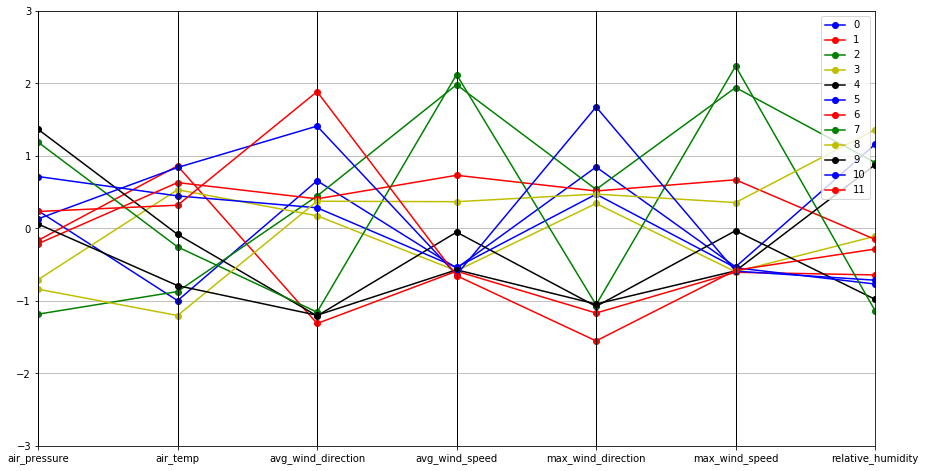

In [33]:
parallel_plot(P[P['relative_humidity'] < 2]) #-0.5

# Warm Days

/home/onofre/anaconda3/envs/UABC_ML_Workshop/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  


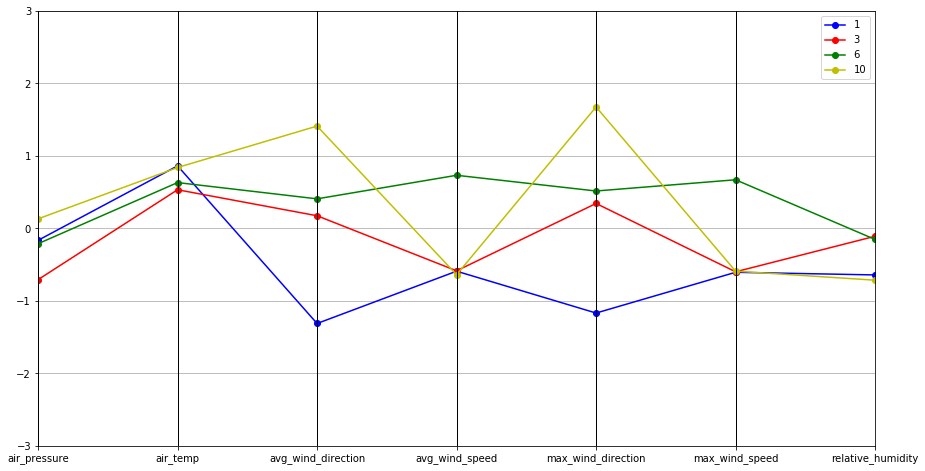

In [31]:
parallel_plot(P[P['air_temp'] > 0.5])

# Cold Days

/home/onofre/anaconda3/envs/UABC_ML_Workshop/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  


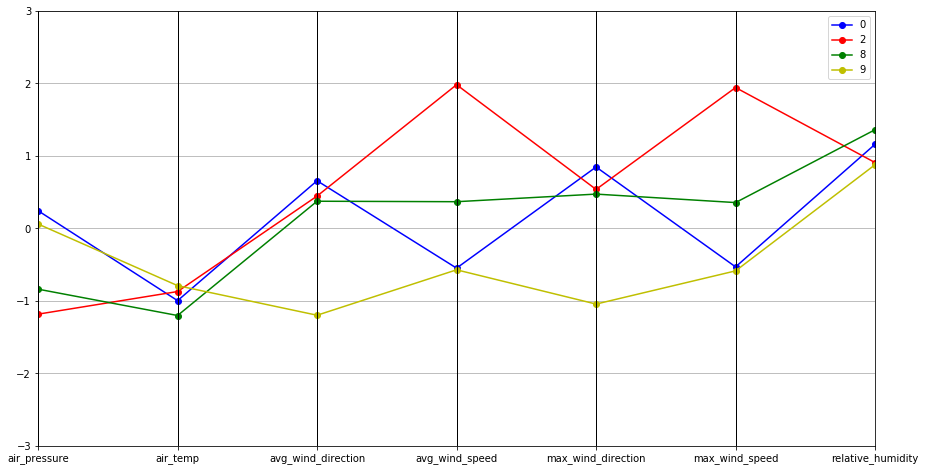

In [27]:
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])